### Example 10 - Scrapmetal Arbitrage Backtest

In this example, we analyze scrapmetal arbitrage opportunites over three months of opportunities.
We'll attempt to answer the following questions:

1. What are the average and median daily returns?
2. What are the average and median daily profits?
3. Are some days of the week more profitable \(or return better\) than others?
4. Are certain times of day more profitable \(or return better\) than others?
5. Are certain source materials more profitable \(or return better\) than others?
6. What is the distribution of opportunities?
7. Which opportunities are the most important to capture?

Answers to these questions will help us determine the long-term viability of this strategy.

In [1]:
# Standard imports
import pandas as pd
import numpy as np
from pandas import DataFrame, Series
import matplotlib.ticker as tck
import matplotlib.pyplot as plt
import datetime
%matplotlib inline
# EveKit imports
from evekit.reference import Client
from evekit.util import convert_raw_time

In [2]:
# We've collected results from our backtest into a CSV file with format:
#
# snapshot time, profit, gross, cost, type
#
# We'll start by reading this data into an array.
#
results_file = "scrap_backtest_20170101_20170331.csv"

opportunities = []
fin = open(results_file, 'r')
for line in fin:
    columns = line.strip().split(",")
    opportunities.append(dict(time=datetime.datetime.strptime(columns[0], "%Y-%m-%d %H:%M:%S"),
                             profit=float(columns[1]),
                             gross=float(columns[2]),
                             cost=float(columns[3]),
                             type=columns[4]))

In [3]:
# Our offline script exploits parallelism to find opportunities more quickly (but a day
# of data still takes four hours to analyze).  A side effect is that our list of opportunities
# is unsorted, so we'll first sort by opportunity time.
opportunities = sorted(opportunities, key=lambda x: x['time'])

In [4]:
# Now we're ready to clean the list, collapsing adjacent opportunities into
# their first occurrence.  We'll use the same function as before:
def clean_opportunities(opps):
    new_opps = []
    stamp_map = {}
    types = set([x['type'] for x in opps])
    # Flatten opportunites for each type
    for next_type in types:
        stamp_list = []
        last = None
        for i in [x['time'] for x in opps if x['type'] == next_type]:
            if last is None:
                # First opportunity
                stamp_list.append(i)
            elif i - last > datetime.timedelta(minutes=5):
                # Start of new run
                stamp_list.append(i)
            last = i
        stamp_map[next_type] = stamp_list
    # Rebuild opportunities by only selecting opportunities in
    # the flattened lists.
    for opp in opps:
        type = opp['type']
        if opp['time'] in stamp_map[type]:
            new_opps.append(opp)
    # Return the new opportunity list
    return new_opps

opportunities = clean_opportunities(opportunities)

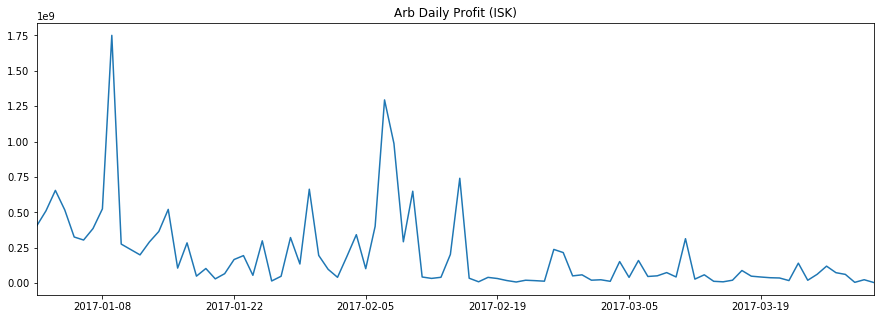

In [5]:
# Now let's convert the results into a DataFrame and take a look at the data
opps_df = DataFrame(opportunities, index=[x['time'] for x in opportunities])

# We can get daily statistics with some simple grouping
groups = opps_df.groupby(opps_df.index.date)

# Let's look at daily proft
profit_series = groups.profit.sum()
profit_series.plot(figsize=[15,5], title="Arb Daily Profit (ISK)")

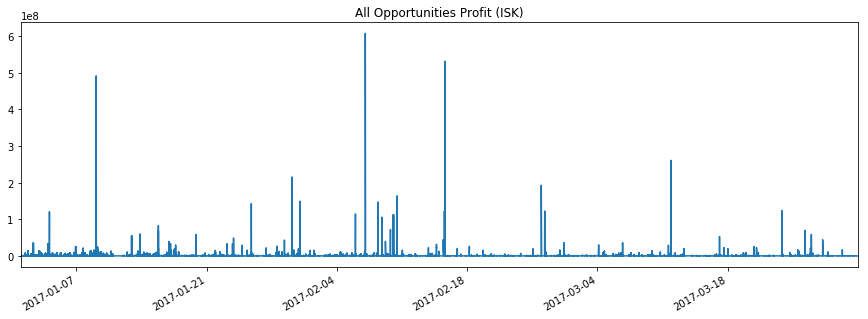

In [6]:
# As in the ore and ice case, there appear to be a few unusually large days.  Let's look at the per
# opportunity data to see if there are any obvious outliers.  Again, these may be completely valid
# opportunities, but leaving them in the data will skew our statistical analysis.
opps_df.profit.plot(figsize=[15,5], title="All Opportunities Profit (ISK)")

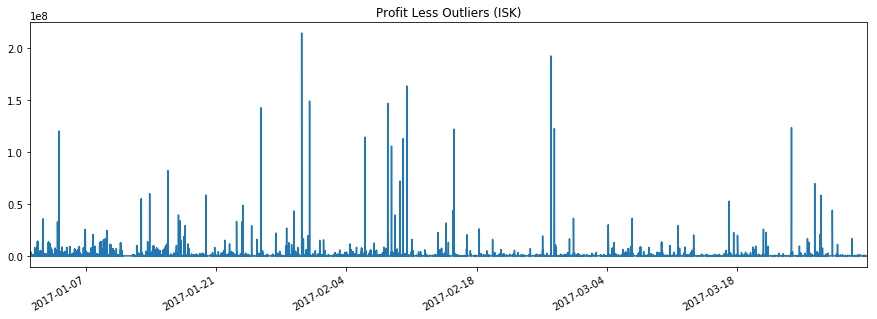

In [7]:
# From the data, we see obvious outliers above 250M ISK.  Let's filter above this threshold.
opps_df[opps_df.profit < 250000000].profit.plot(figsize=[15,5], title="Profit Less Outliers (ISK)")

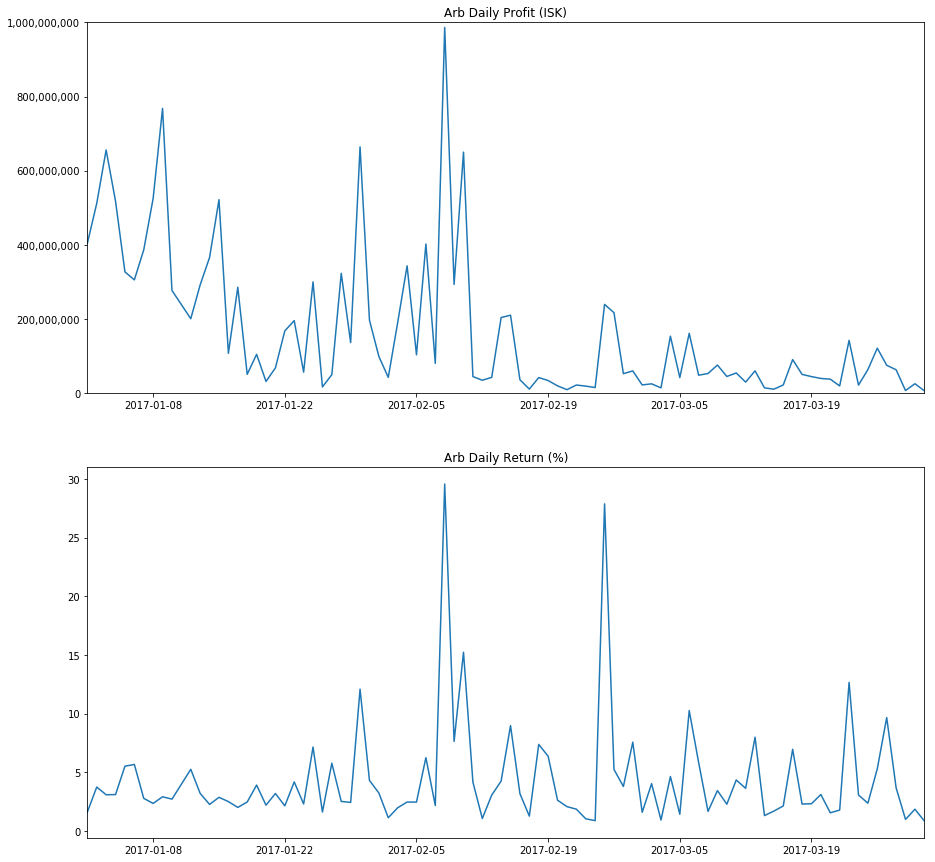

In [8]:
# We could filter even further, but we'll stop here as the remaining data seems to reasonably capture expected results.
# Now let's take a look at profit and return over time.
opps_filtered_df = opps_df[opps_df.profit < 250000000]
groups = opps_filtered_df.groupby(opps_filtered_df.index.date)
profit_series = groups.profit.sum()
return_series = groups.profit.sum() / groups.cost.sum() * 100

fig = plt.figure()
ax1 = fig.add_subplot(2,1,1)
ax1.get_yaxis().set_major_formatter(tck.FuncFormatter(lambda y, p: format(int(y), ',')))
ax1.set_ylim([0, 1000000000])
ax2 = fig.add_subplot(2,1,2)
profit_series.plot(ax=ax1, figsize=[15,15], title="Arb Daily Profit (ISK)")
return_series.plot(ax=ax2, figsize=[15,15], title="Arb Daily Return (%)")

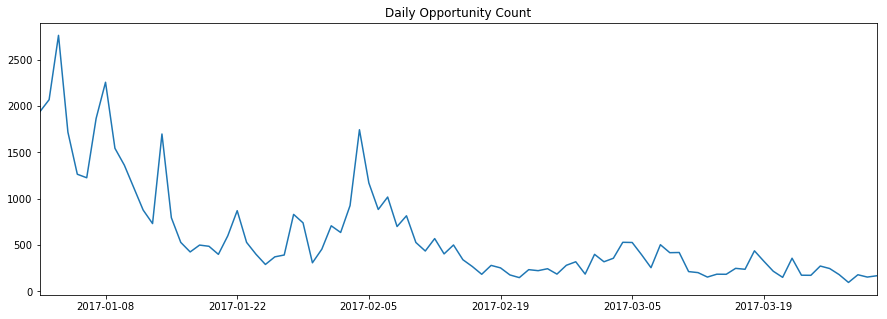

In [9]:
# Profit is consistently strong until March, while returns remain fairly steady
# except for a few spikes in February.  The marked change in profit without
# a change in returns suggests the number of opportunities went down in March.
# We can easily test our intuition here by adding an opportunity count plot.
#
groups = opps_filtered_df.groupby(opps_filtered_df.index.date)
count_series = groups.profit.count()
ax = count_series.plot(figsize=[15,5], title="Daily Opportunity Count")

In [10]:
# And indeed we see a very strong drop in opportunities.  Why would this be
# the case?  There are many possible explanations: seasonal effects; market
# activity moving elsewhere (e.g. player-owned stations); improved market
# efficiency (unlikely); etc.
#
# Let's look at some aggregates based on this data.

# Average daily profit
print("Average daily profit: %s\n" % "{:,.2f}".format(profit_series.mean()))

# Average daily return
print("Average daily return: %s%%\n" % "{:,.2f}".format(return_series.mean()))

# Average daily opportunity count
print("Average daily opportunities: %s\n" % "{:,d}".format(int(count_series.mean())))

# Median daily profit
print("Median daily profit: %s\n" % "{:,.2f}".format(profit_series.quantile(0.5)))

# Median daily return
print("Median daily return: %s%%\n" % "{:,.2f}".format(return_series.quantile(0.5)))

# Median daily opportunity count
print("Median daily opportunities: %s\n" % "{:,d}".format(int(count_series.quantile(0.5))))

Average daily profit: 167,839,891.69

Average daily return: 4.36%

Average daily opportunities: 599

Median daily profit: 67,819,153.43

Median daily return: 3.05%

Median daily opportunities: 401



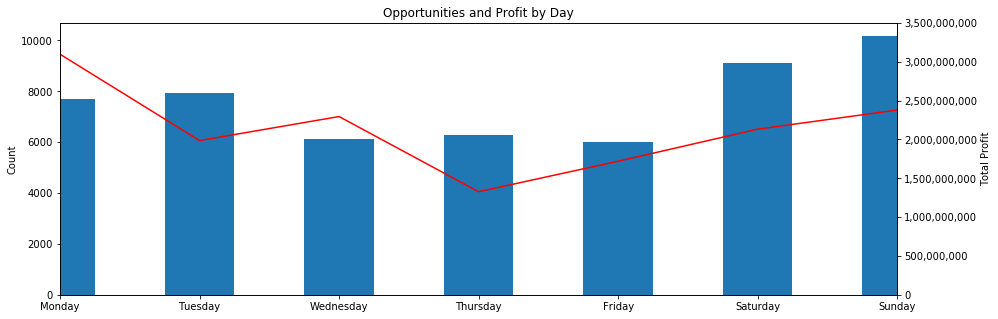

In [11]:
# These numbers are better than ore and ice, which is perhaps not surprising given how many
# more types can generate opportunities.  On the other hand, maximum scrapmetal efficiency is 
# much lower than ore and ice, so the profitability here is somewhat surprising.  The
# significant difference between average and median is a reflection of the slowdown in
# March, and the few large days early in the quarter.
#
# Let's see if scrapmetal follows the same day of week trends as ore and ice (which showed
# surprisingly low profit on weekends).
#
by_dow = opps_filtered_df.groupby(opps_filtered_df.index.dayofweek)
by_dow_count = by_dow.profit.count().rename({0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',
                                             4:'Friday',5:'Saturday',6:'Sunday'})
by_dow_sum = by_dow.profit.sum().rename({0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',
                                         4:'Friday',5:'Saturday',6:'Sunday'})
#
# Now we can overlay opportunity count with total profit per day
#
ax1 = by_dow_count.plot(kind='bar', figsize=[15,5], title="Opportunities and Profit by Day")
ax1.set_ylabel("Count")
ax2 = by_dow_sum.plot(secondary_y=True, style='r')
ax2.set_ylabel("Total Profit")
ax2.set_ylim([0, 3500000000])
ax2.get_yaxis().set_major_formatter(tck.FuncFormatter(lambda y, p: format(int(y), ',')))

These results are quite different than ore and ice in which opportunity and profit peaked on Tuesday.  Scrapmetal arbitrage opportunities are centered around the weekend which is what we would typically expect.  However, Monday has emerged as the peak profit day for this strategy, even though most opportunities occur on Sunday.

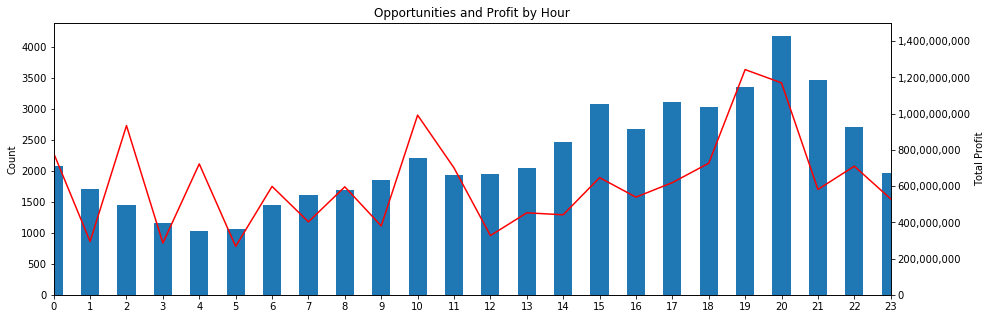

In [12]:
# Now let's consider whether certain times of day are more profitable.
# We can group by hour of the day to analyze this data.
#
by_hour = opps_filtered_df.groupby(opps_filtered_df.index.hour)
by_hour_count = by_hour.profit.count()
by_hour_sum = by_hour.profit.sum()
#
# Now we can overlay opportunity count with total profit per hour
#
ax1 = by_hour_count.plot(kind='bar', figsize=[15,5], title="Opportunities and Profit by Hour")
ax1.set_ylabel("Count")
ax2 = by_hour_sum.plot(secondary_y=True, style='r')
ax2.set_ylabel("Total Profit")
ax2.set_ylim([0, 1500000000])
ax2.get_yaxis().set_major_formatter(tck.FuncFormatter(lambda y, p: format(int(y), ',')))

As is the case with ore and ice, there is a very clear runup from midnight to a peak at 20:00 \(UTC\).  Unlike ore and ice, however, the opportunity count peak aligns very closely with the profit peak.  Being ready to strike around 20:00 seems to be very profitable with this strategy.  The other two profitable peaks may coincide with timezone behavior.

In [13]:
# We ended our analysis of ore and ice by considering which source materials are the most profitable.
# There are likely too many materials for scrapmetal processing to consider them all.
# To verify:
by_type = opps_filtered_df.groupby(opps_filtered_df.type)
len(by_type.profit.all())

738

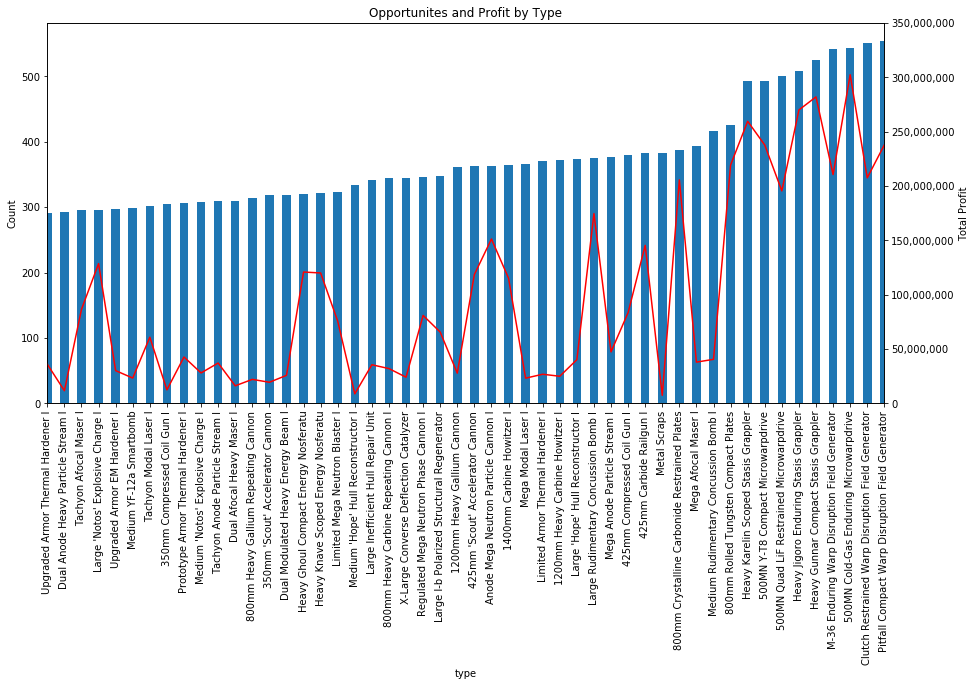

In [14]:
# Instead of considering all materials, we'll only consider the largest 50 by opportunity count.
#
window = 50
by_type = opps_filtered_df.groupby(opps_filtered_df.type)
by_type_count = by_type.profit.count()
by_type_sum = by_type.profit.sum()
top_counts = by_type_count.sort_values(ascending=False).index[:window]
#
# Now we can overlay opportunity count with total profit by type.
# For this example, it's useful to sort by count to allow variants
# of source material to be grouped together
#
low_to_high = by_type_count.ix[top_counts].sort_values().index
ax1 = by_type_count.ix[low_to_high].plot(kind='bar', figsize=[15,7], sharex=True, title="Opportunites and Profit by Type")
ax1.set_ylabel("Count")
ax2 = by_type_sum.ix[low_to_high].plot(secondary_y=True, style='r', rot=90, sharex=True)
ax2.set_ylabel("Total Profit")
ax2.set_ylim([0, 350000000])
ax2.get_yaxis().set_major_formatter(tck.FuncFormatter(lambda y, p: format(int(y), ',')))
ax2.get_xaxis().set_visible(False)

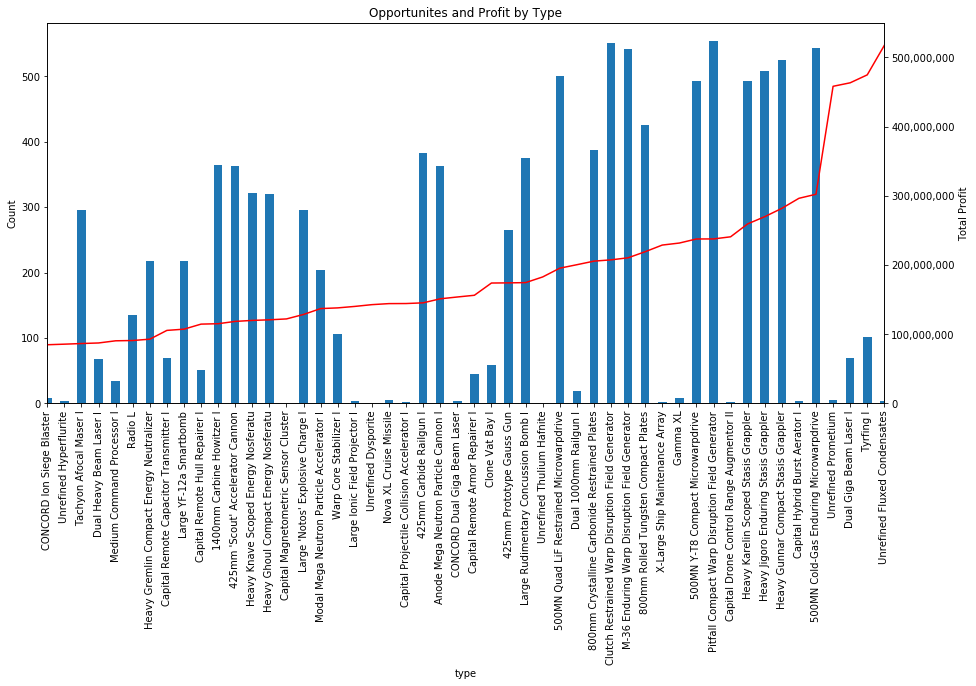

In [15]:
# Profitability roughly follows opportunity counts but what about the overall most profitable
# opportunities?  We can view that breakdown by sorting by total profit instead of count.
# We'll only consider the largest 50 by total profit.
#
window = 50
by_type = opps_filtered_df.groupby(opps_filtered_df.type)
by_type_count = by_type.profit.count()
by_type_sum = by_type.profit.sum()
top_sums = by_type_sum.sort_values(ascending=False).index[:window]
#
# Now we can overlay opportunity count with total profit by type.
# For this example, it's useful to sort by count to allow variants
# of source material to be grouped together
#
low_to_high = by_type_sum.ix[top_sums].sort_values().index
ax1 = by_type_count.ix[low_to_high].plot(kind='bar', figsize=[15,7], sharex=True, title="Opportunites and Profit by Type")
ax1.set_ylabel("Count")
ax2 = by_type_sum.ix[low_to_high].plot(secondary_y=True, style='r', rot=90, sharex=True)
ax2.set_ylabel("Total Profit")
ax2.set_ylim([0, 550000000])
ax2.get_yaxis().set_major_formatter(tck.FuncFormatter(lambda y, p: format(int(y), ',')))
ax2.get_xaxis().set_visible(False)

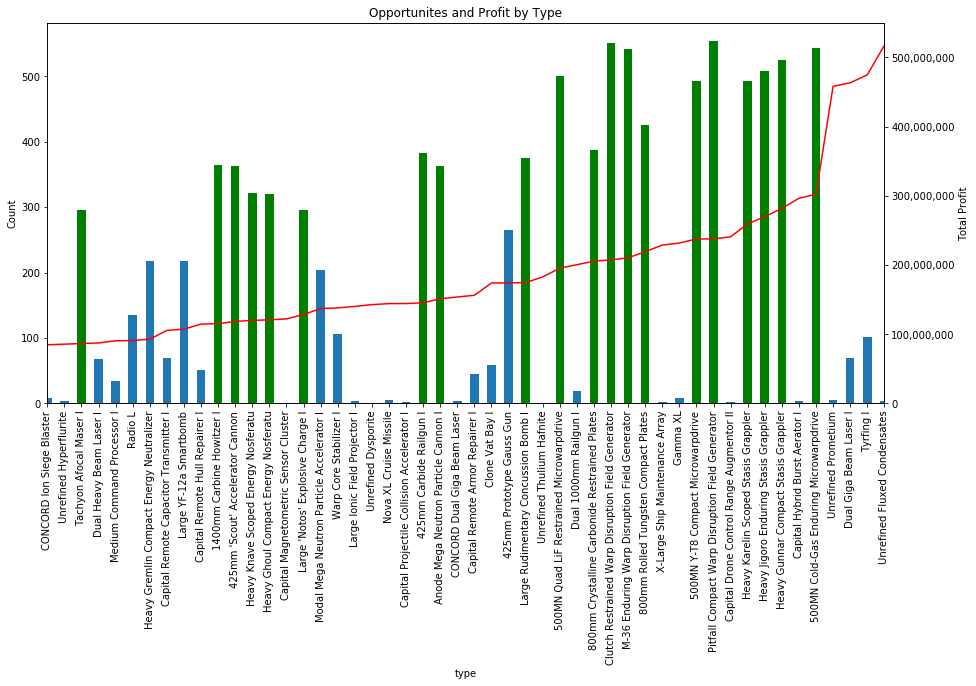

In [16]:
# There's not much of a pattern here.  But we can get some interesting perspective by highlighting
# the types which appear in both lists (in green).
window = 50
by_type = opps_filtered_df.groupby(opps_filtered_df.type)
by_type_count = by_type.profit.count()
by_type_sum = by_type.profit.sum()
top_counts = by_type_count.sort_values(ascending=False).index[:window]
top_sums = by_type_sum.sort_values(ascending=False).index[:window]
sums_only = set(top_sums).difference(top_counts)
#
# Generate a new series which zeros out the types which aren't in
# top_counts.  We'll plot this on top of the top_sums plot.
#
by_type_count_cp = by_type_count.copy()
by_type_count_cp[sums_only] = 0
#
# Then overlay the profit plot
#
low_to_high = by_type_sum.ix[top_sums].sort_values().index
ax1 = by_type_count.ix[low_to_high].plot(kind='bar', figsize=[15,7], sharex=True, title="Opportunites and Profit by Type")
by_type_count_cp.ix[low_to_high].plot(ax=ax1, kind='bar', color='g')
ax1.set_ylabel("Count")
ax2 = by_type_sum.ix[low_to_high].plot(secondary_y=True, style='r', rot=90, sharex=True)
ax2.set_ylabel("Total Profit")
ax2.set_ylim([0, 550000000])
ax2.get_yaxis().set_major_formatter(tck.FuncFormatter(lambda y, p: format(int(y), ',')))
ax2.get_xaxis().set_visible(False)

Many of the most common opportunities also appear in the most profitable list which is a good sign: you're more likely to catch a frequent opportunity and this chart says there's a good chance it will be highly profitable as well.

(0, 1000000)

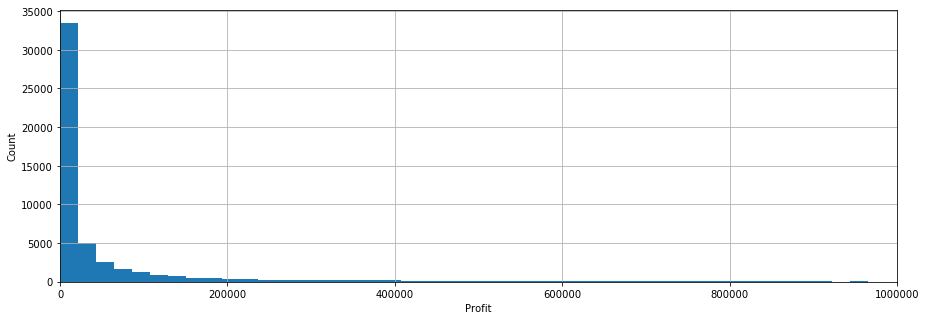

In [17]:
# As a final bit of analysis, let's take a look at the distribution of opportunities.  This will tell us
# how frequently we might expect to see opportunities of a certain size.  Note that we've already eliminated
# a few outliers so those results won't skew the distribution.  We'll limit the profit range to 10M ISK.
ax1 = opps_filtered_df.profit.hist(bins=10000, figsize=[15,5])
ax1.set_ylabel("Count")
ax1.set_xlabel("Profit")
ax1.set_xlim([0, 1000000])

(0, 2000)

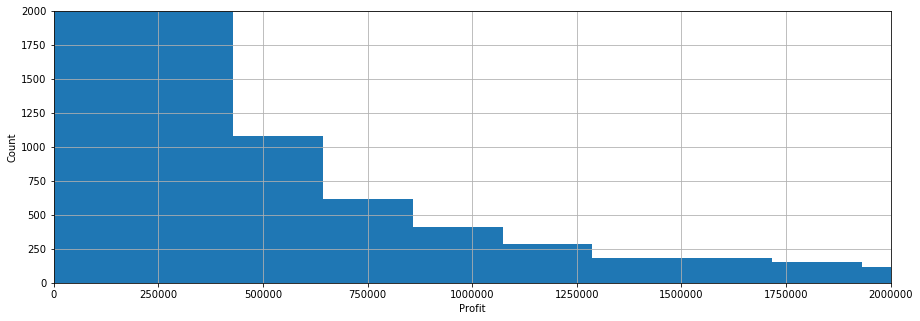

In [18]:
# We don't get much information from this distribution other than that the vast majority of opportunities
# are well less than 200000 ISK.  These would add up if we were to take them all, but that could get
# very tedious.  We can stretch the profit range a bit and shrink the count range to get a better picture
# of opportunities up to 2M ISK.
ax1 = opps_filtered_df.profit.hist(bins=1000, figsize=[15,5])
ax1.set_ylabel("Count")
ax1.set_xlabel("Profit")
ax1.set_xlim([0, 2000000])
ax1.set_ylim([0, 2000])

In [19]:
# The number of opportunities drops rapidly past 1M ISK.  How significant is
# this behavior?  Some simple statistics can help us answer this question.
#
# First, let's look at how often opportunities over 1M ISK occur as a percentage of all opportunities.
#
total_ops = opps_filtered_df.size
large_ops = opps_filtered_df[opps_filtered_df.profit >= 1000000].size
print("Large opps count ratio: %s%%" % "{:,.2f}".format(large_ops / total_ops * 100))
#
# Now, let's look at how important those large opportunities are in terms of profit.
#
total_ops_profit = opps_filtered_df.profit.sum()
large_ops_profit = opps_filtered_df[opps_filtered_df.profit >= 1000000].profit.sum()
print("Large opp profit ratio: %s%%" % "{:,.2f}".format(large_ops_profit / total_ops_profit * 100))

Large opps count ratio: 3.89%
Large opp profit ratio: 78.92%


So while the number of large opportunities is small, this is where the majority of the profit resides.  This suggests a simple trading strategy where we wait for large opportunities, then try to be the first to grab them.  Opportunites larger than 1M ISK seems like a good place to start.  Is there an even better threshold?  Let's compute these same statistics for a selection of other thresholds.

In [51]:
total_ops = opps_filtered_df.size
total_ops_profit = opps_filtered_df.profit.sum()
for threshold in [100000 * x for x in range(0, 11)]:
    above_threshold = opps_filtered_df[opps_filtered_df.profit >= threshold]
    large_ops = above_threshold.size
    large_ops_profit = above_threshold.profit.sum()
    count_ratio = large_ops / total_ops * 100
    profit_ratio = large_ops_profit / total_ops_profit * 100
    groups = above_threshold.groupby(above_threshold.index.date)
    profit_series = groups.profit.sum()
    return_series = groups.profit.sum() / groups.cost.sum() * 100
    count_series = groups.profit.count()
    avg_daily_profit = profit_series.mean()
    avg_daily_count = count_series.mean()
    avg_daily_return = return_series.mean()
    mdn_daily_profit = profit_series.quantile(0.5)
    mdn_daily_count = count_series.quantile(0.5)
    mdn_daily_return = return_series.quantile(0.5)
    print("T:%s C%%: %s%% P%%: %s%% Avg P: %s Avg C: %s Avg R: %s%% Mdn P: %s Mdn C: %s Mdn R: %s%%" % 
          ("{:7d}".format(threshold), "{:6,.2f}".format(count_ratio), "{:6,.2f}".format(profit_ratio),
           "{:8,.2f}".format(avg_daily_profit), "{:3d}".format(int(avg_daily_count)), "{:5,.2f}".format(avg_daily_return),
           "{:8,.2f}".format(mdn_daily_profit), "{:3d}".format(int(mdn_daily_count)), "{:5,.2f}".format(mdn_daily_return)))


T:      0 C%: 100.00% P%: 100.00% Avg P: 167,839,891.69 Avg C: 599 Avg R:  4.36% Mdn P: 67,819,153.43 Mdn C: 401 Mdn R:  3.05%
T: 100000 C%:  18.35% P%:  95.62% Avg P: 160,487,317.75 Avg C: 109 Avg R:  6.10% Mdn P: 61,590,329.67 Mdn C:  52 Mdn R:  4.43%
T: 200000 C%:  12.49% P%:  92.66% Avg P: 155,512,127.32 Avg C:  74 Avg R:  7.00% Mdn P: 61,314,238.44 Mdn C:  34 Mdn R:  5.05%
T: 300000 C%:   9.75% P%:  90.26% Avg P: 151,491,759.55 Avg C:  58 Avg R:  7.86% Mdn P: 60,707,451.35 Mdn C:  25 Mdn R:  5.26%
T: 400000 C%:   7.92% P%:  87.99% Avg P: 147,676,821.07 Avg C:  47 Avg R:  8.43% Mdn P: 57,938,619.09 Mdn C:  16 Mdn R:  5.81%
T: 500000 C%:   6.70% P%:  86.02% Avg P: 144,370,246.89 Avg C:  40 Avg R:  9.29% Mdn P: 55,355,420.41 Mdn C:  16 Mdn R:  6.24%
T: 600000 C%:   5.85% P%:  84.37% Avg P: 141,608,897.20 Avg C:  35 Avg R:  9.63% Mdn P: 54,874,745.35 Mdn C:  14 Mdn R:  6.61%
T: 700000 C%:   5.24% P%:  82.95% Avg P: 139,223,348.79 Avg C:  31 Avg R: 10.27% Mdn P: 54,202,057.81 Mdn C:  1

Note the large drop in daily opportunity count at a threshold as small as 100K ISK, while still capturing the majority of profit for a day.  Note also that return increases significantly as threshold is increased, roughly tripling at 1M ISK as compared to no threshold.  While most EVE players would find it tedious to process 400 \(median\) opportunities a day, it may be reasonable to process 20 to 30 opportunities.  The right threshold for you is a matter of personal choice.